In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
import xgboost as xgb


In [ ]:
df = pd.read_csv('/content/CleanedDataCrime.csv')

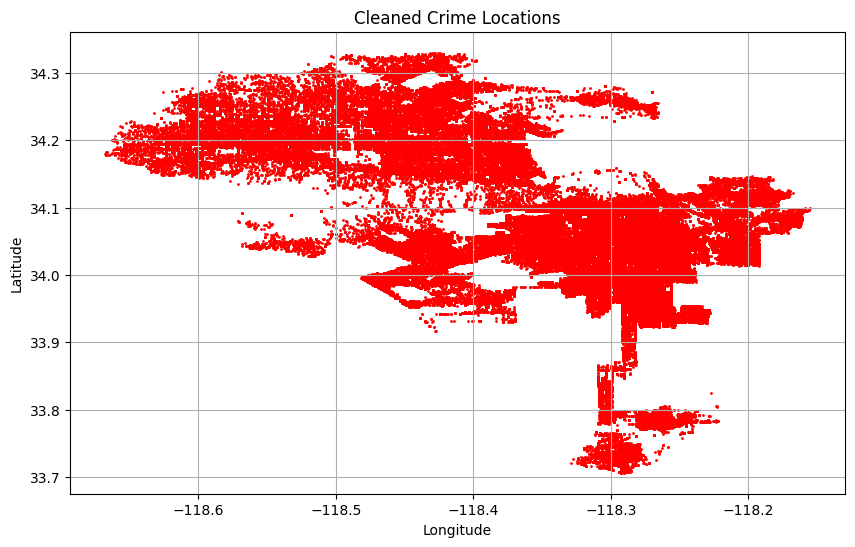

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset (replace with your actual data loading method)
# For example:
df = pd.read_csv('/content/CleanedDataCrime.csv')


# Remove points where Latitude is between 4 and 4.02 to clean up the cluster
# df_cleaned = df[(df['LAT'] < 33.8) | (df['LAT'] > 33.9)]
df_cleaned = df

# Plot the cleaned data
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['LON'], df_cleaned['LAT'], c='red', s=1)
plt.title('Cleaned Crime Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


Sampled Data Shape: (90000, 2)

Processing chunks of the sampled data...
Processing chunk 1/2...
Processing chunk 2/2...

Clustered Data Sample:
         LAT         LON  Cluster
0  33.238385 -117.522663        0
1  33.063194 -117.924553        0
2  33.773481 -117.173925        1
3  33.808192 -117.666050        2
4  33.277088 -117.870787        0
The location (33.75, -118.3) is in Cluster ID 2.
Danger Likelihood: 24.98%

Plotting the clusters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


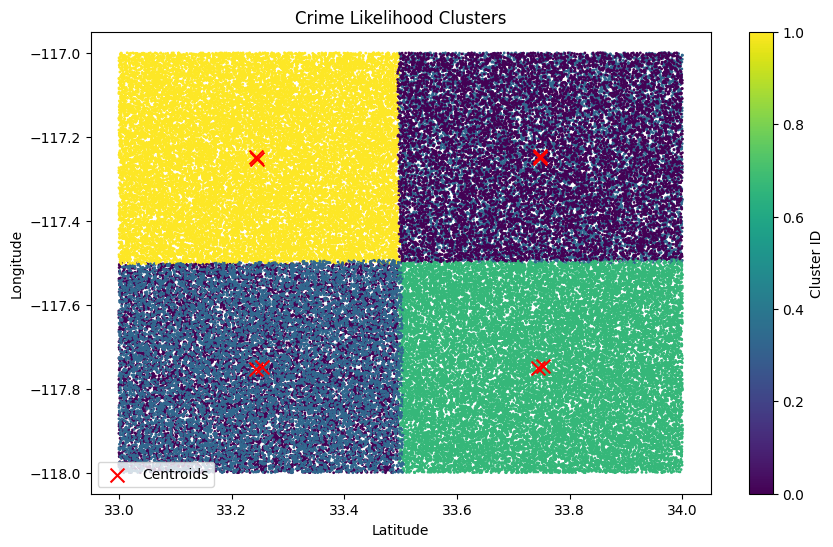


Plotting the clusters with the input location...


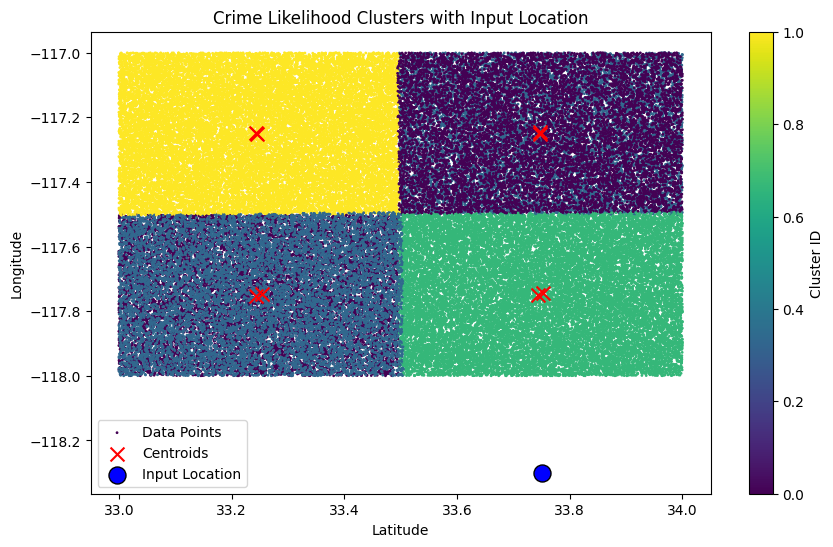

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class CrimeLikelihoodAnalyzerKMeans:
    def __init__(self, n_clusters=5):
        """
        Initialize the analyzer with a K-Means clustering model and preprocessing tools.
        """
        self.model = KMeans(n_clusters=n_clusters, random_state=42)
        self.scaler = StandardScaler()
        self.cluster_labels = None

    def preprocess_data(self, df):
        """
        Preprocess the input DataFrame:
        - Select relevant columns (LAT, LON)
        - Scale numerical columns
        """
        # Keep only latitude and longitude columns
        relevant_cols = ["LAT", "LON"]
        df = df[relevant_cols].copy()

        # Fill missing values with the mean (if any)
        df = df.fillna(df.mean())

        # Scale numerical columns
        scaled_data = self.scaler.fit_transform(df)

        return scaled_data, df

    def train_model(self, df):
        """
        Train the K-Means clustering model and label the data with cluster IDs.
        """
        # Preprocess data
        features, preprocessed_df = self.preprocess_data(df)

        # Fit K-Means
        self.cluster_labels = self.model.fit_predict(features)
        preprocessed_df["Cluster"] = self.cluster_labels

        # Get cluster centroids
        centroids = self.model.cluster_centers_

        return preprocessed_df, centroids

# Function to process data in chunks
def process_in_chunks(df, chunk_size, analyzer):
    """
    Process data in smaller chunks to avoid memory issues.
    """
    num_chunks = len(df) // chunk_size + 1
    chunk_results = []
    cluster_centroids = []

    for i in range(num_chunks):
        chunk = df.iloc[i * chunk_size: (i + 1) * chunk_size]

        # Skip empty chunks
        if chunk.empty:
            print(f"Skipping empty chunk {i + 1}/{num_chunks}.")
            continue

        print(f"Processing chunk {i + 1}/{num_chunks}...")
        clustered_chunk, centroids = analyzer.train_model(chunk)
        chunk_results.append(clustered_chunk)
        cluster_centroids.extend(centroids)

    # Concatenate all chunks
    full_result = pd.concat(chunk_results, ignore_index=True)

    return full_result, cluster_centroids

def predict_danger(lat, lon, clustered_df, analyzer):
    """
    Predict the danger percentage of a given latitude and longitude based on clustering results.

    Parameters:
        lat (float): Latitude of the input location.
        lon (float): Longitude of the input location.
        clustered_df (pd.DataFrame): The clustered data containing 'LAT', 'LON', and 'Cluster'.
        analyzer (CrimeLikelihoodAnalyzerKMeans): The trained K-Means analyzer.

    Returns:
        danger_percentage (float): The predicted danger likelihood (0-100%).
        cluster_id (int): The cluster ID to which the location belongs.
    """
    # Scale the input coordinates using the scaler
    input_coords = analyzer.scaler.transform([[lat, lon]])

    # Predict the cluster of the input location
    cluster_label = analyzer.model.predict(input_coords)[0]

    # Filter the cluster
    cluster_points = clustered_df[clustered_df["Cluster"] == cluster_label]

    # Calculate danger percentage (e.g., based on cluster density)
    total_points = len(clustered_df)
    cluster_density = len(cluster_points) / total_points
    danger_percentage = cluster_density * 100

    return danger_percentage, cluster_label

# Main Script
if __name__ == "__main__":
    # Simulate a large dataset for demonstration
    np.random.seed(42)
    data_size = 100000
    df_cleaned = pd.DataFrame({
        "LAT": np.random.uniform(33, 34, data_size),
        "LON": np.random.uniform(-118, -117, data_size)
    })

    # Step 1: Downsample the dataset
    sample_fraction = 0.9
    df_sampled = df_cleaned.sample(frac=sample_fraction, random_state=42)
    print(f"Sampled Data Shape: {df_sampled.shape}")

    # Step 2: Process sampled data in chunks
    chunk_size = 50000
    analyzer = CrimeLikelihoodAnalyzerKMeans(n_clusters=4)

    print("\nProcessing chunks of the sampled data...")
    clustered_df, cluster_centroids = process_in_chunks(df_sampled, chunk_size, analyzer)

    # Display results
    print(f"\nClustered Data Sample:")
    print(clustered_df.head())

    # User-provided coordinates
    user_lat = 33.75
    user_lon = -118.3

    # Predict danger likelihood
    danger_percentage, cluster_id = predict_danger(user_lat, user_lon, clustered_df, analyzer)

    print(f"The location ({user_lat}, {user_lon}) is in Cluster ID {cluster_id}.")
    print(f"Danger Likelihood: {danger_percentage:.2f}%")

    # Plotting the clusters
    print("\nPlotting the clusters...")
    plt.figure(figsize=(10, 6))
    plt.scatter(clustered_df['LAT'], clustered_df['LON'], c=clustered_df['Cluster'], cmap='viridis', s=1)
    # plt.scatter(
    #     [c[0] for c in cluster_centroids],
    #     [c[1] for c in cluster_centroids],
    #     c='red', label='Centroids', marker='x'
    # )

    # Convert centroids back to original scale
    original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

    # Plot the centroids on the original scale
    plt.scatter(
        original_centroids[:, 0],  # Latitude in original scale
        original_centroids[:, 1],  # Longitude in original scale
        c='red', label='Centroids', marker='x', s=100
    )

    plt.colorbar(label='Cluster ID')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Crime Likelihood Clusters')
    plt.legend()
    plt.show()

        # Plotting the clusters with the input location
    print("\nPlotting the clusters with the input location...")
    plt.figure(figsize=(10, 6))

    # Plot all the clustered data points
    plt.scatter(
        clustered_df['LAT'], clustered_df['LON'],
        c=clustered_df['Cluster'], cmap='viridis', s=1, label='Data Points'
    )

    # Convert centroids back to original scale
    original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

    # Plot the centroids
    plt.scatter(
        original_centroids[:, 0],  # Latitude in original scale
        original_centroids[:, 1],  # Longitude in original scale
        c='red', label='Centroids', marker='x', s=100
    )

    # Highlight the input location
    plt.scatter(
        user_lat, user_lon,
        c='blue', label='Input Location', marker='o', edgecolor='black', s=150
    )

    # Add labels and legend
    plt.colorbar(label='Cluster ID')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Crime Likelihood Clusters with Input Location')
    plt.legend()
    plt.show()



# predict Danger and Plot it

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

1. Location (33.2, -117.8) -> Cluster ID: 1, Danger Likelihood: 25.61%
2. Location (33.3, -117.7) -> Cluster ID: 1, Danger Likelihood: 25.61%
3. Location (33.4, -117.6) -> Cluster ID: 1, Danger Likelihood: 25.61%
4. Location (33.5, -117.5) -> Cluster ID: 1, Danger Likelihood: 25.61%
5. Location (33.6, -117.4) -> Cluster ID: 0, Danger Likelihood: 24.61%
6. Location (33.7, -117.3) -> Cluster ID: 0, Danger Likelihood: 24.61%
7. Location (33.8, -117.2) -> Cluster ID: 0, Danger Likelihood: 24.61%
8. Location (33.9, -117.1) -> Cluster ID: 0, Danger Likelihood: 24.61%
9. Location (34.0, -117.0) -> Cluster ID: 0, Danger Likelihood: 24.61%
10. Location (34.1, -116.9) -> Cluster ID: 0, Danger Likelihood: 24.61%


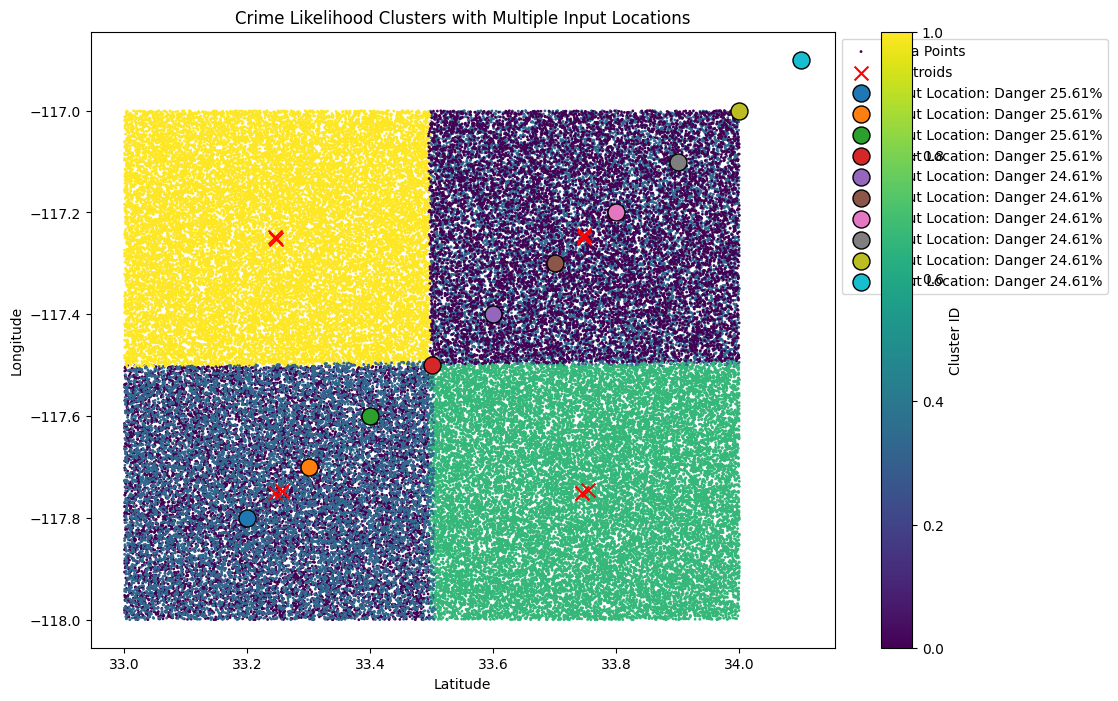

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define an array of 10 coordinates (latitude, longitude)
input_coordinates = [
    (33.2, -117.8), (33.3, -117.7), (33.4, -117.6), (33.5, -117.5), (33.6, -117.4),
    (33.7, -117.3), (33.8, -117.2), (33.9, -117.1), (34.0, -117.0), (34.1, -116.9)
]

# Placeholder to store results
results = []

# Loop through each coordinate to predict danger likelihood
for user_lat, user_lon in input_coordinates:
    # Predict danger percentage and cluster ID
    danger_percentage, cluster_id = predict_danger(user_lat, user_lon, clustered_df, analyzer)
    results.append((user_lat, user_lon, cluster_id, danger_percentage))

# Print the results
for idx, (lat, lon, cluster_id, danger) in enumerate(results):
    print(f"{idx + 1}. Location ({lat}, {lon}) -> Cluster ID: {cluster_id}, Danger Likelihood: {danger:.2f}%")

# Plotting the clusters with all input locations
plt.figure(figsize=(12, 8))

# Plot clustered data points
plt.scatter(
    clustered_df['LAT'], clustered_df['LON'],
    c=clustered_df['Cluster'], cmap='viridis', s=1, label='Data Points'
)

# Convert centroids back to original scale
original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

# Plot the centroids
plt.scatter(
    original_centroids[:, 0],  # Latitude in original scale
    original_centroids[:, 1],  # Longitude in original scale
    c='red', label='Centroids', marker='x', s=100
)

# Highlight the input locations
for lat, lon, _, danger in results:
    plt.scatter(
        lat, lon,
        label=f"Input Location: Danger {danger:.2f}%",
        marker='o', edgecolor='black', s=150
    )

# Add labels and legend
plt.colorbar(label='Cluster ID')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Crime Likelihood Clusters with Multiple Input Locations')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


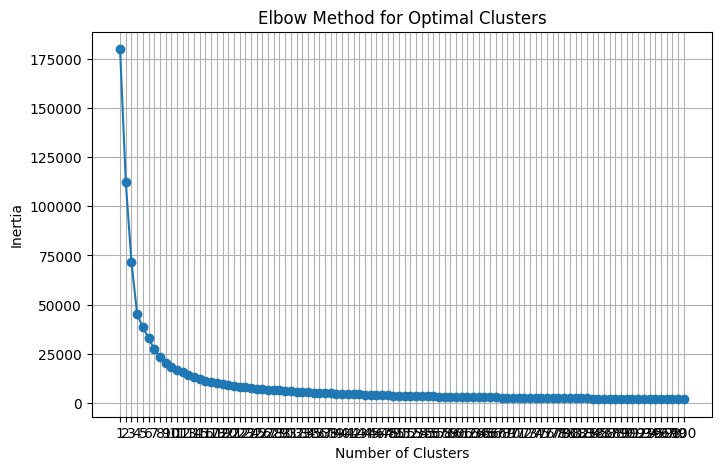

In [ ]:
def find_optimal_clusters_elbow(data, max_clusters=10):
    """
    Use the Elbow Method to find the optimal number of clusters.
    """
    inertias = []
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xticks(cluster_range)
    plt.grid()
    plt.show()

# Preprocess the data and find the optimal number of clusters
scaled_data, _ = analyzer.preprocess_data(df_sampled)
find_optimal_clusters_elbow(scaled_data,100)


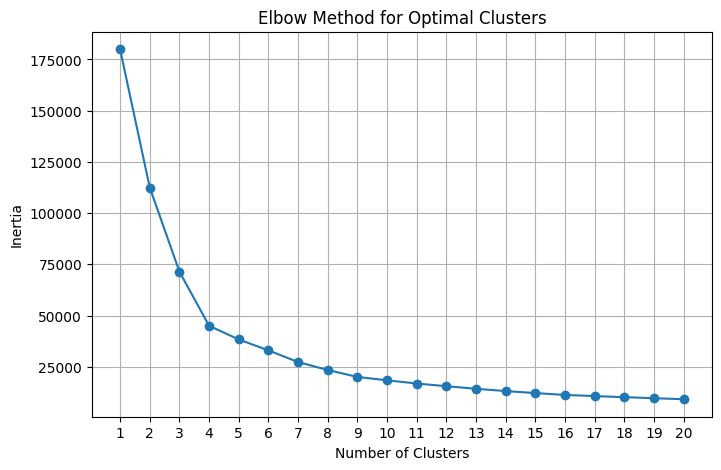

In [ ]:
def find_optimal_clusters_elbow(data, max_clusters=10):
    """
    Use the Elbow Method to find the optimal number of clusters.
    """
    inertias = []
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertias, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Clusters')
    plt.xticks(cluster_range)
    plt.grid()
    plt.show()

# Preprocess the data and find the optimal number of clusters
scaled_data, _ = analyzer.preprocess_data(df_sampled)
find_optimal_clusters_elbow(scaled_data,20)


best option is 4

# new formula to calculate Danger

Sampled Data Shape: (90000, 2)

Processing chunks of the sampled data...
Processing chunk 1/2...
Processing chunk 2/2...

Clustered Data Sample:
         LAT         LON  Cluster
0  33.238385 -117.522663        0
1  33.063194 -117.924553        0
2  33.773481 -117.173925        1
3  33.808192 -117.666050        2
4  33.277088 -117.870787        0
The location (33.75, -118.3) is in Cluster ID 2.
Danger Likelihood: 24.98%

Plotting the clusters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


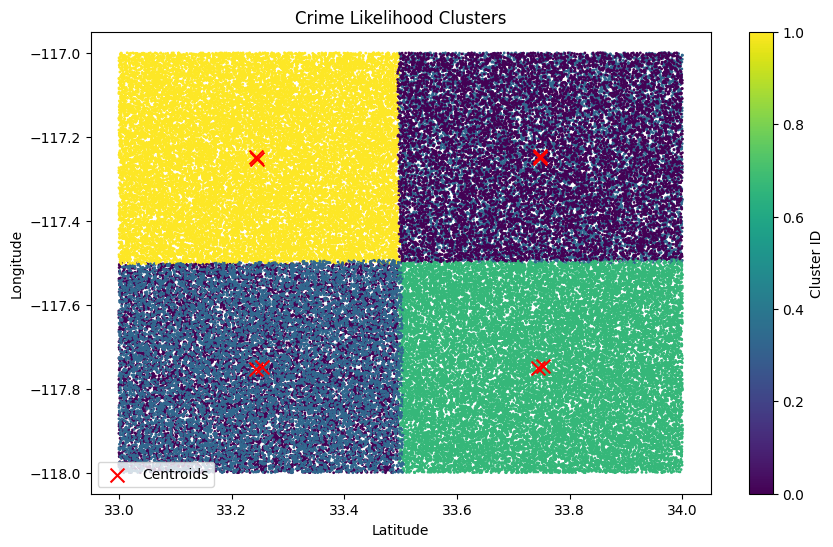


Plotting the clusters with the input location...


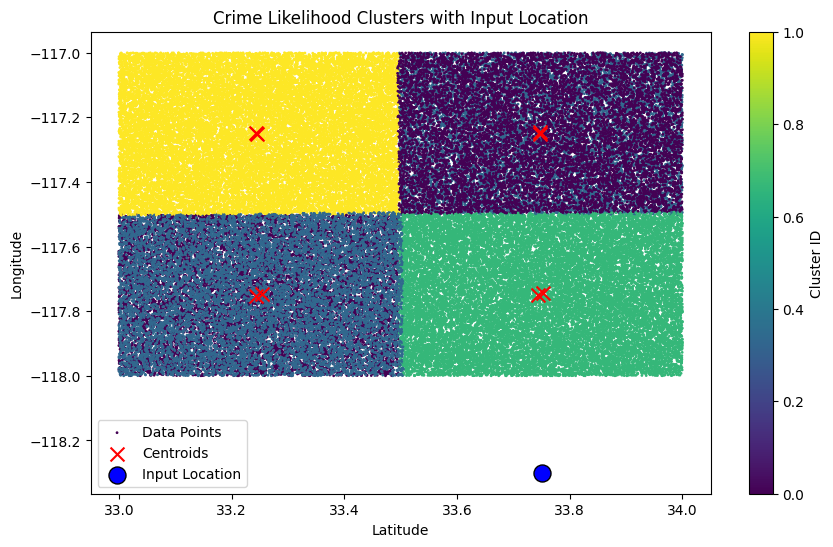

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class CrimeLikelihoodAnalyzerKMeans:
    def __init__(self, n_clusters=5):
        """
        Initialize the analyzer with a K-Means clustering model and preprocessing tools.
        """
        self.model = KMeans(n_clusters=n_clusters, random_state=42)
        self.scaler = StandardScaler()
        self.cluster_labels = None

    def preprocess_data(self, df):
        """
        Preprocess the input DataFrame:
        - Select relevant columns (LAT, LON)
        - Scale numerical columns
        """
        # Keep only latitude and longitude columns
        relevant_cols = ["LAT", "LON"]
        df = df[relevant_cols].copy()

        # Fill missing values with the mean (if any)
        df = df.fillna(df.mean())

        # Scale numerical columns
        scaled_data = self.scaler.fit_transform(df)

        return scaled_data, df

    def train_model(self, df):
        """
        Train the K-Means clustering model and label the data with cluster IDs.
        """
        # Preprocess data
        features, preprocessed_df = self.preprocess_data(df)

        # Fit K-Means
        self.cluster_labels = self.model.fit_predict(features)
        preprocessed_df["Cluster"] = self.cluster_labels

        # Get cluster centroids
        centroids = self.model.cluster_centers_

        return preprocessed_df, centroids

# Function to process data in chunks
def process_in_chunks(df, chunk_size, analyzer):
    """
    Process data in smaller chunks to avoid memory issues.
    """
    num_chunks = len(df) // chunk_size + 1
    chunk_results = []
    cluster_centroids = []

    for i in range(num_chunks):
        chunk = df.iloc[i * chunk_size: (i + 1) * chunk_size]

        # Skip empty chunks
        if chunk.empty:
            print(f"Skipping empty chunk {i + 1}/{num_chunks}.")
            continue

        print(f"Processing chunk {i + 1}/{num_chunks}...")
        clustered_chunk, centroids = analyzer.train_model(chunk)
        chunk_results.append(clustered_chunk)
        cluster_centroids.extend(centroids)

    # Concatenate all chunks
    full_result = pd.concat(chunk_results, ignore_index=True)

    return full_result, cluster_centroids

def calculate_danger_likelihood(lat, lon, clustered_df, analyzer, density_weight=0.2, distance_weight=0.8):
    """
    Calculate danger likelihood for a given latitude and longitude.

    Parameters:
        lat (float): Latitude of the location.
        lon (float): Longitude of the location.
        clustered_df (pd.DataFrame): The clustered data containing 'LAT', 'LON', and 'Cluster'.
        analyzer (CrimeLikelihoodAnalyzerKMeans): Trained K-Means analyzer.
        density_weight (float): Weight for cluster density.
        distance_weight (float): Weight for distance to centroid.

    Returns:
        danger_percentage (float): Danger likelihood (0-100%).
        cluster_id (int): Cluster ID.
    """
    # Scale the input coordinates
    input_coords = analyzer.scaler.transform([[lat, lon]])
    cluster_label = analyzer.model.predict(input_coords)[0]

    # Get cluster data
    cluster_points = clustered_df[clustered_df["Cluster"] == cluster_label]
    cluster_size = len(cluster_points)

    # Calculate cluster density
    total_points = len(clustered_df)
    cluster_density = cluster_size / total_points

    # Find the centroid for this cluster (scaled back to original space)
    centroid = analyzer.scaler.inverse_transform([analyzer.model.cluster_centers_[cluster_label]])[0]

    # Calculate the Euclidean distance to the centroid
    distance_to_centroid = np.linalg.norm(np.array([lat, lon]) - np.array(centroid))

    # Normalize the distance within this cluster
    max_cluster_distance = cluster_points.apply(
        lambda row: np.linalg.norm(np.array([row["LAT"], row["LON"]]) - np.array(centroid)),
        axis=1
    ).max()
    normalized_distance = distance_to_centroid / max_cluster_distance if max_cluster_distance > 0 else 0

    # Combine density and distance to calculate danger percentage
    danger_percentage = (
        density_weight * (cluster_density * 100) +
        distance_weight * ((1 - normalized_distance) * 100)
    )

    # Ensure percentage stays within [0, 100]
    danger_percentage = max(0, min(danger_percentage, 100))

    return danger_percentage, cluster_label



# Main Script
if __name__ == "__main__":
    # Simulate a large dataset for demonstration
    np.random.seed(42)
    data_size = 100000
    df_cleaned = pd.DataFrame({
        "LAT": np.random.uniform(33, 34, data_size),
        "LON": np.random.uniform(-118, -117, data_size)
    })

    # Step 1: Downsample the dataset
    sample_fraction = 0.9
    df_sampled = df_cleaned.sample(frac=sample_fraction, random_state=42)
    print(f"Sampled Data Shape: {df_sampled.shape}")

    # Step 2: Process sampled data in chunks
    chunk_size = 50000
    analyzer = CrimeLikelihoodAnalyzerKMeans(n_clusters=4)

    print("\nProcessing chunks of the sampled data...")
    clustered_df, cluster_centroids = process_in_chunks(df_sampled, chunk_size, analyzer)

    # Display results
    print(f"\nClustered Data Sample:")
    print(clustered_df.head())

    # User-provided coordinates
    user_lat = 33.75
    user_lon = -118.3

    # Predict danger likelihood
    danger_percentage, cluster_id = predict_danger(user_lat, user_lon, clustered_df, analyzer )

    print(f"The location ({user_lat}, {user_lon}) is in Cluster ID {cluster_id}.")
    print(f"Danger Likelihood: {danger_percentage:.2f}%")

    # Plotting the clusters
    print("\nPlotting the clusters...")
    plt.figure(figsize=(10, 6))
    plt.scatter(clustered_df['LAT'], clustered_df['LON'], c=clustered_df['Cluster'], cmap='viridis', s=1)
    # plt.scatter(
    #     [c[0] for c in cluster_centroids],
    #     [c[1] for c in cluster_centroids],
    #     c='red', label='Centroids', marker='x'
    # )

    # Convert centroids back to original scale
    original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

    # Plot the centroids on the original scale
    plt.scatter(
        original_centroids[:, 0],  # Latitude in original scale
        original_centroids[:, 1],  # Longitude in original scale
        c='red', label='Centroids', marker='x', s=100
    )

    plt.colorbar(label='Cluster ID')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Crime Likelihood Clusters')
    plt.legend()
    plt.show()

        # Plotting the clusters with the input location
    print("\nPlotting the clusters with the input location...")
    plt.figure(figsize=(10, 6))

    # Plot all the clustered data points
    plt.scatter(
        clustered_df['LAT'], clustered_df['LON'],
        c=clustered_df['Cluster'], cmap='viridis', s=1, label='Data Points'
    )

    # Convert centroids back to original scale
    original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

    # Plot the centroids
    plt.scatter(
        original_centroids[:, 0],  # Latitude in original scale
        original_centroids[:, 1],  # Longitude in original scale
        c='red', label='Centroids', marker='x', s=100
    )

    # Highlight the input location
    plt.scatter(
        user_lat, user_lon,
        c='blue', label='Input Location', marker='o', edgecolor='black', s=150
    )

    # Add labels and legend
    plt.colorbar(label='Cluster ID')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Crime Likelihood Clusters with Input Location')
    plt.legend()
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

1. Location (33.2, -117.8) -> Cluster ID: 1, Danger Likelihood: 24.23%
2. Location (33.3, -117.7) -> Cluster ID: 1, Danger Likelihood: 24.42%
3. Location (33.4, -117.6) -> Cluster ID: 1, Danger Likelihood: 21.86%
4. Location (33.5, -117.5) -> Cluster ID: 1, Danger Likelihood: 19.30%
5. Location (33.6, -117.4) -> Cluster ID: 0, Danger Likelihood: 20.90%
6. Location (33.7, -117.3) -> Cluster ID: 0, Danger Likelihood: 23.36%
7. Location (33.8, -117.2) -> Cluster ID: 0, Danger Likelihood: 23.39%
8. Location (33.9, -117.1) -> Cluster ID: 0, Danger Likelihood: 20.93%
9. Location (34.0, -117.0) -> Cluster ID: 0, Danger Likelihood: 18.47%
10. Location (34.1, -116.9) -> Cluster ID: 0, Danger Likelihood: 16.01%


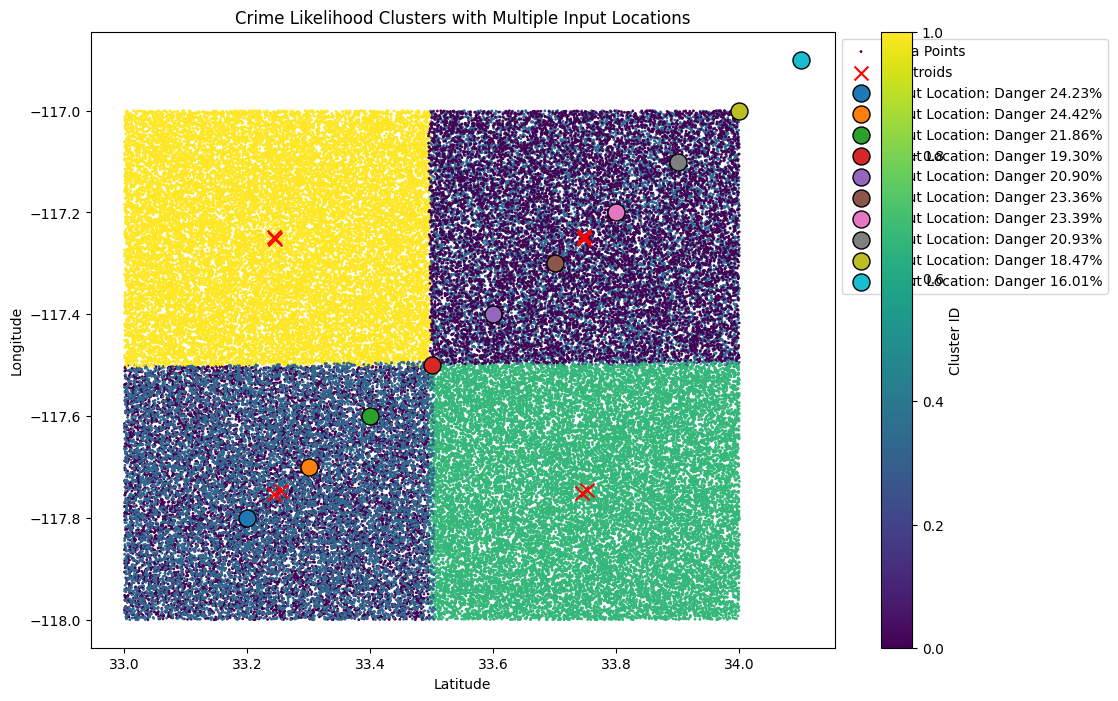

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define an array of 10 coordinates (latitude, longitude)
input_coordinates = [
    (33.2, -117.8), (33.3, -117.7), (33.4, -117.6), (33.5, -117.5), (33.6, -117.4),
    (33.7, -117.3), (33.8, -117.2), (33.9, -117.1), (34.0, -117.0), (34.1, -116.9)
]

# Placeholder to store results
results = []

# Loop through each coordinate to predict danger likelihood
for user_lat, user_lon in input_coordinates:
    # Predict danger percentage and cluster ID
    danger_percentage, cluster_id = predict_danger(user_lat, user_lon, clustered_df, analyzer)
    results.append((user_lat, user_lon, cluster_id, danger_percentage))

# Print the results
for idx, (lat, lon, cluster_id, danger) in enumerate(results):
    print(f"{idx + 1}. Location ({lat}, {lon}) -> Cluster ID: {cluster_id}, Danger Likelihood: {danger:.2f}%")

# Plotting the clusters with all input locations
plt.figure(figsize=(12, 8))

# Plot clustered data points
plt.scatter(
    clustered_df['LAT'], clustered_df['LON'],
    c=clustered_df['Cluster'], cmap='viridis', s=1, label='Data Points'
)

# Convert centroids back to original scale
original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

# Plot the centroids
plt.scatter(
    original_centroids[:, 0],  # Latitude in original scale
    original_centroids[:, 1],  # Longitude in original scale
    c='red', label='Centroids', marker='x', s=100
)

# Highlight the input locations
for lat, lon, _, danger in results:
    plt.scatter(
        lat, lon,
        label=f"Input Location: Danger {danger:.2f}%",
        marker='o', edgecolor='black', s=150
    )

# Add labels and legend
plt.colorbar(label='Cluster ID')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Crime Likelihood Clusters with Multiple Input Locations')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

1. Location (33.2, -117.8) -> Cluster ID: 1, Danger Likelihood: 86.07%
2. Location (33.3, -117.7) -> Cluster ID: 1, Danger Likelihood: 86.94%
3. Location (33.4, -117.6) -> Cluster ID: 1, Danger Likelihood: 74.84%
4. Location (33.5, -117.5) -> Cluster ID: 1, Danger Likelihood: 62.73%
5. Location (33.6, -117.4) -> Cluster ID: 0, Danger Likelihood: 74.32%
6. Location (33.7, -117.3) -> Cluster ID: 0, Danger Likelihood: 86.35%
7. Location (33.8, -117.2) -> Cluster ID: 0, Danger Likelihood: 86.49%
8. Location (33.9, -117.1) -> Cluster ID: 0, Danger Likelihood: 74.46%
9. Location (34.0, -117.0) -> Cluster ID: 0, Danger Likelihood: 62.42%
10. Location (34.1, -116.9) -> Cluster ID: 0, Danger Likelihood: 50.37%


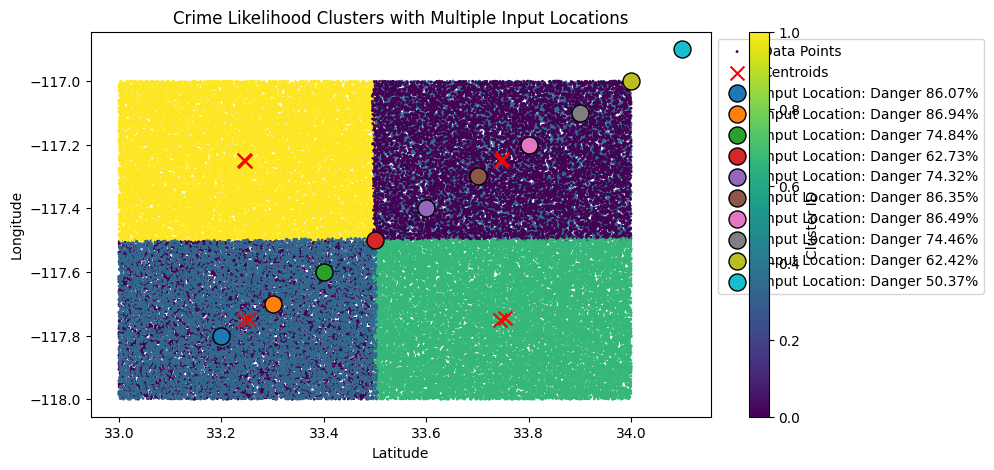

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define an array of 10 coordinates (latitude, longitude)
input_coordinates = [
    (33.2, -117.8), (33.3, -117.7), (33.4, -117.6), (33.5, -117.5), (33.6, -117.4),
    (33.7, -117.3), (33.8, -117.2), (33.9, -117.1), (34.0, -117.0), (34.1, -116.9)
]

# Placeholder to store results
results = []

# Loop through each coordinate to predict danger likelihood
for user_lat, user_lon in input_coordinates:
    # Predict danger percentage and cluster ID
    danger_percentage, cluster_id = calculate_danger_likelihood(user_lat, user_lon, clustered_df, analyzer , density_weight=0.1 , distance_weight=0.9)
    results.append((user_lat, user_lon, cluster_id, danger_percentage))

# Print the results
for idx, (lat, lon, cluster_id, danger) in enumerate(results):
    print(f"{idx + 1}. Location ({lat}, {lon}) -> Cluster ID: {cluster_id}, Danger Likelihood: {danger:.2f}%")

# Plotting the clusters with all input locations
plt.figure(figsize=(10, 5))

# Plot clustered data points
plt.scatter(
    clustered_df['LAT'], clustered_df['LON'],
    c=clustered_df['Cluster'], cmap='viridis', s=1, label='Data Points'
)

# Convert centroids back to original scale
original_centroids = analyzer.scaler.inverse_transform(cluster_centroids)

# Plot the centroids
plt.scatter(
    original_centroids[:, 0],  # Latitude in original scale
    original_centroids[:, 1],  # Longitude in original scale
    c='red', label='Centroids', marker='x', s=100
)

# Highlight the input locations
for lat, lon, _, danger in results:
    plt.scatter(
        lat, lon,
        label=f"Input Location: Danger {danger:.2f}%",
        marker='o', edgecolor='black', s=150
    )

# Add labels and legend
plt.colorbar(label='Cluster ID')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Crime Likelihood Clusters with Multiple Input Locations')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mock-up example: Generate clustered_df and analyzer for demonstration
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Generate synthetic data for clustering
np.random.seed(42)
data = np.random.rand(5000, 2) * [1, -1] + [33, -118]  # Random latitude and longitude points

# Scale and cluster data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
kmeans = KMeans(n_clusters=4, random_state=42).fit(scaled_data)

# Create a DataFrame for the clustered data
clustered_df = pd.DataFrame(data, columns=['LAT', 'LON'])
clustered_df['Cluster'] = kmeans.labels_

# Mock analyzer with clustering and scaling
class MockAnalyzer:
    def __init__(self, kmeans, scaler):
        self.cluster_centers_ = kmeans.cluster_centers_
        self.scaler = scaler

analyzer = MockAnalyzer(kmeans, scaler)

# Function to calculate danger likelihood
def calculate_danger_likelihood(lat, lon, clustered_df, analyzer, density_weight=0.1, distance_weight=0.9):
    """
    Calculate danger likelihood based on proximity to centroids and density of points in the cluster.
    """
    # Convert input coordinates to scaled values (if clustering was done on scaled data)
    scaled_coords = analyzer.scaler.transform([[lat, lon]])[0]

    # Calculate distances to all centroids
    distances = np.linalg.norm(analyzer.cluster_centers_ - scaled_coords, axis=1)

    # Find the nearest cluster
    nearest_cluster = np.argmin(distances)
    nearest_distance = distances[nearest_cluster]

    # Danger likelihood based on proximity to centroid
    max_distance = np.max(distances)
    proximity_score = max(0, 1 - nearest_distance / max_distance)  # Linear decay

    # Density-based danger (optional, if density is provided)
    cluster_density = clustered_df[clustered_df['Cluster'] == nearest_cluster].shape[0]
    max_density = clustered_df['Cluster'].value_counts().max()
    density_score = cluster_density / max_density

    # Combine the scores
    danger_likelihood = (distance_weight * proximity_score + density_weight * density_score) * 100

    return danger_likelihood, nearest_cluster

# Define an array of 10 coordinates (latitude, longitude)
input_coordinates = [
    (33.2, -118.8), (33.3, -117.7), (33.4, -117.6), (33.5, -117.5), (33.6, -117.4),
    (33.7, -117.3), (33.1, -118.2), (33.9, -118.1), (33.2, -117.0), (34.1, -116.9)
]

# Placeholder to store results
results = []

# Loop through each coordinate to predict danger likelihood
for user_lat, user_lon in input_coordinates:
    danger_percentage, cluster_id = calculate_danger_likelihood(
        user_lat, user_lon, clustered_df, analyzer, density_weight=0.1, distance_weight=0.9
    )
    results.append((user_lat, user_lon, cluster_id, danger_percentage))

# Print the results
for idx, (lat, lon, cluster_id, danger) in enumerate(results):
    print(f"{idx + 1}. Location ({lat}, {lon}) -> Cluster ID: {cluster_id}, Danger Likelihood: {danger:.2f}%")


1. Location (33.2, -118.8) -> Cluster ID: 3, Danger Likelihood: 92.00%
2. Location (33.3, -117.7) -> Cluster ID: 0, Danger Likelihood: 54.97%
3. Location (33.4, -117.6) -> Cluster ID: 0, Danger Likelihood: 48.47%
4. Location (33.5, -117.5) -> Cluster ID: 2, Danger Likelihood: 45.01%
5. Location (33.6, -117.4) -> Cluster ID: 2, Danger Likelihood: 44.97%
6. Location (33.7, -117.3) -> Cluster ID: 2, Danger Likelihood: 44.15%
7. Location (33.1, -118.2) -> Cluster ID: 0, Danger Likelihood: 83.19%
8. Location (33.9, -118.1) -> Cluster ID: 2, Danger Likelihood: 79.19%
9. Location (33.2, -117.0) -> Cluster ID: 0, Danger Likelihood: 37.54%
10. Location (34.1, -116.9) -> Cluster ID: 2, Danger Likelihood: 38.54%


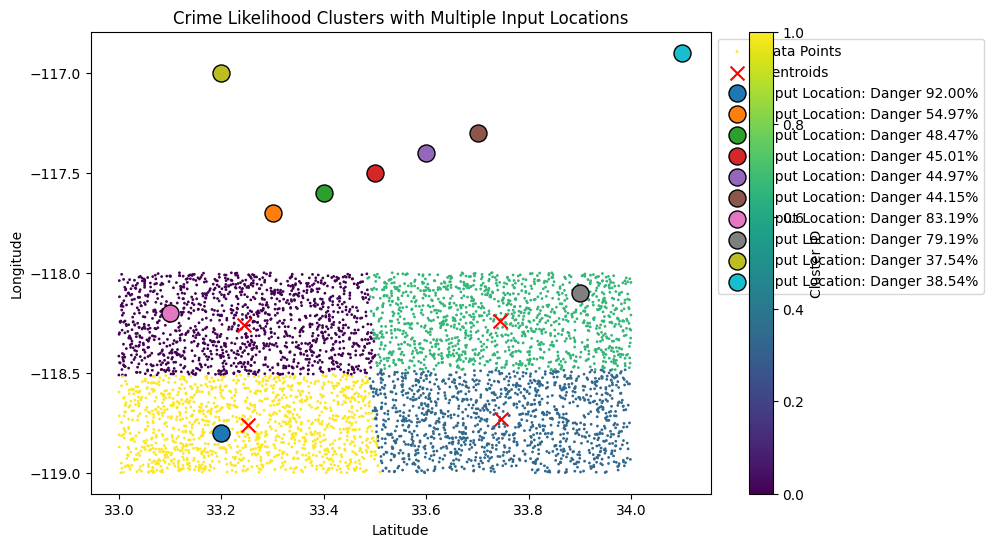

In [ ]:
# Plotting the clusters with all input locations
plt.figure(figsize=(10, 6))

# Plot clustered data points
plt.scatter(
    clustered_df['LAT'], clustered_df['LON'],
    c=clustered_df['Cluster'], cmap='viridis', s=1, label='Data Points'
)

# Convert centroids back to original scale
original_centroids = analyzer.scaler.inverse_transform(analyzer.cluster_centers_)

# Plot the centroids
plt.scatter(
    original_centroids[:, 0],  # Latitude in original scale
    original_centroids[:, 1],  # Longitude in original scale
    c='red', label='Centroids', marker='x', s=100
)

# Highlight the input locations
for lat, lon, _, danger in results:
    plt.scatter(
        lat, lon,
        label=f"Input Location: Danger {danger:.2f}%",
        marker='o', edgecolor='black', s=150
    )

# Add labels and legend
plt.colorbar(label='Cluster ID')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Crime Likelihood Clusters with Multiple Input Locations')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()


<ipython-input-33-c90402af0e3d>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = kmeans.labels_  # Add cluster labels to the data


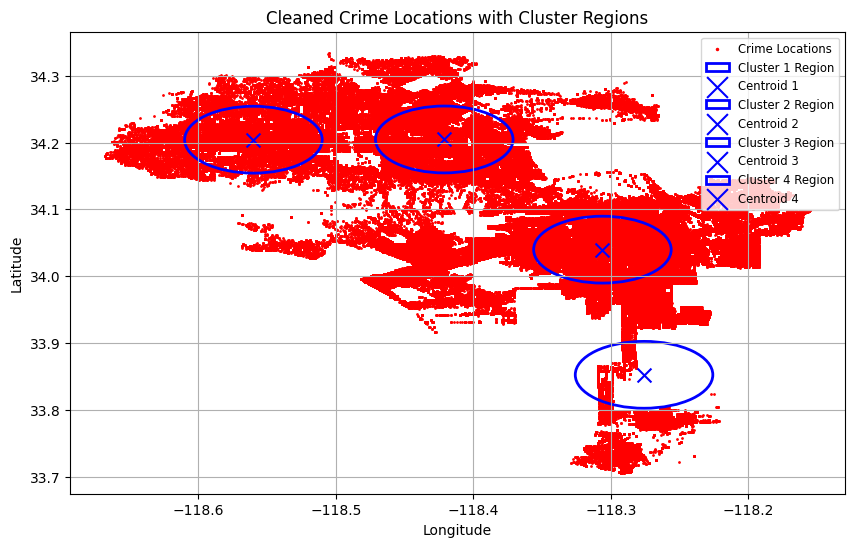

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Load the dataset
df = pd.read_csv('/content/CleanedDataCrime.csv')

# Step 2: Clean the data (if needed)
df_cleaned = df[['LAT', 'LON']]  # Extract latitude and longitude columns

# Step 3: Apply K-Means clustering
num_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(df_cleaned)

# Get cluster labels and centroids
df_cleaned['Cluster'] = kmeans.labels_  # Add cluster labels to the data
cluster_centroids = kmeans.cluster_centers_  # Get centroids

# Step 4: Plot the cleaned crime locations
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['LON'], df_cleaned['LAT'], c='red', s=1, label="Crime Locations")

# Step 5: Add circles and centroids to represent clusters
radii = [0.05] * num_clusters  # Define uniform radii for visualization
for i, (lat, lon) in enumerate(cluster_centroids):
    circle = plt.Circle((lon, lat), radii[i], color='blue', fill=False, linewidth=2, label=f"Cluster {i+1} Region")
    plt.gca().add_patch(circle)
    plt.scatter(lon, lat, c='blue', marker='x', s=100, label=f"Centroid {i+1}")

# Customize the plot
plt.title('Cleaned Crime Locations with Cluster Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(loc='upper right', markerscale=1.5, fontsize='small')
plt.show()


<ipython-input-35-21c5497dab63>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = kmeans.labels_  # Add cluster labels to the data


    LAT    LON  Danger_Level Cluster Match_Percentage
0  34.0 -118.4             5       0        86.584327
1  34.2 -118.2             7       0        82.973867
2  34.3 -118.3             8       1        86.467138
3  33.8 -118.5             6       2        83.066591


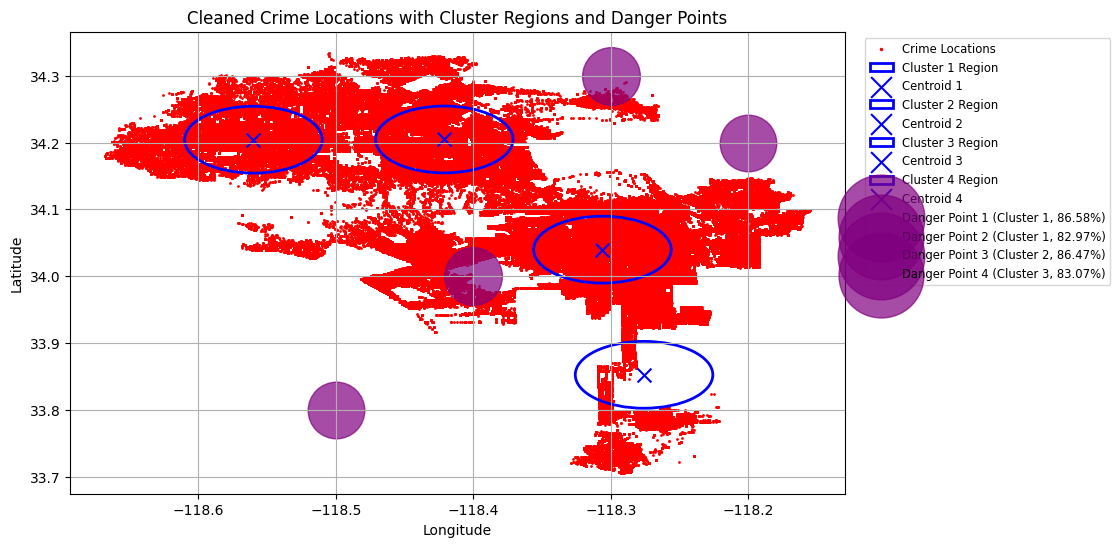

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Step 1: Load the dataset
df = pd.read_csv('/content/CleanedDataCrime.csv')

# Step 2: Clean the data (if needed)
df_cleaned = df[['LAT', 'LON']]  # Extract latitude and longitude columns

# Step 3: Apply K-Means clustering
num_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(df_cleaned)

# Get cluster labels and centroids
df_cleaned['Cluster'] = kmeans.labels_  # Add cluster labels to the data
cluster_centroids = kmeans.cluster_centers_  # Get centroids

# Step 4: Define danger points
danger_points = pd.DataFrame({
    'LAT': [34.0, 34.2, 34.3, 33.8],
    'LON': [-118.4, -118.2, -118.3, -118.5],
    'Danger_Level': [5, 7, 8, 6]  # Higher danger levels for visualization
})

# Step 5: Assign each danger point to the nearest cluster and calculate the percentage match
def calculate_percentage_and_cluster(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    nearest_cluster = np.argmin(distances)
    match_percentage = (1 - distances[nearest_cluster] / distances.sum()) * 100
    return nearest_cluster, match_percentage

danger_points['Cluster'] = None
danger_points['Match_Percentage'] = None

for idx, row in danger_points.iterrows():
    cluster, percentage = calculate_percentage_and_cluster(
        np.array([row['LAT'], row['LON']]), cluster_centroids
    )
    danger_points.at[idx, 'Cluster'] = cluster
    danger_points.at[idx, 'Match_Percentage'] = percentage

# Print danger points with their cluster and percentage
print(danger_points)

# Step 6: Plot the cleaned crime locations
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['LON'], df_cleaned['LAT'], c='red', s=1, label="Crime Locations")

# Add circles and centroids to represent clusters
radii = [0.05] * num_clusters  # Define uniform radii for visualization
for i, (lat, lon) in enumerate(cluster_centroids):
    circle = plt.Circle((lon, lat), radii[i], color='blue', fill=False, linewidth=2, label=f"Cluster {i+1} Region")
    plt.gca().add_patch(circle)
    plt.scatter(lon, lat, c='blue', marker='x', s=100, label=f"Centroid {i+1}")

# Step 7: Plot danger points, scaling circle size by percentage match
for idx, row in danger_points.iterrows():
    plt.scatter(
        row['LON'], row['LAT'],
        s=row['Match_Percentage'] * 20,  # Scale size by match percentage
        c='purple',
        alpha=0.7,
        label=f"Danger Point {idx+1} (Cluster {row['Cluster']+1}, {row['Match_Percentage']:.2f}%)"
    )

# Customize the plot
plt.title('Cleaned Crime Locations with Cluster Regions and Danger Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(loc='upper right', markerscale=1.5, fontsize='small', bbox_to_anchor=(1.35, 1))
plt.show()


<ipython-input-36-2f6c4f21213e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names,

    LAT    LON  Danger_Level  Cluster  Danger_Percentage
0  34.0 -118.4             5      3.0          69.996954
1  34.2 -118.2             7      0.0          60.823146
2  34.3 -118.3             8      3.0          52.353213
3  33.8 -118.5             6      2.0          33.701437


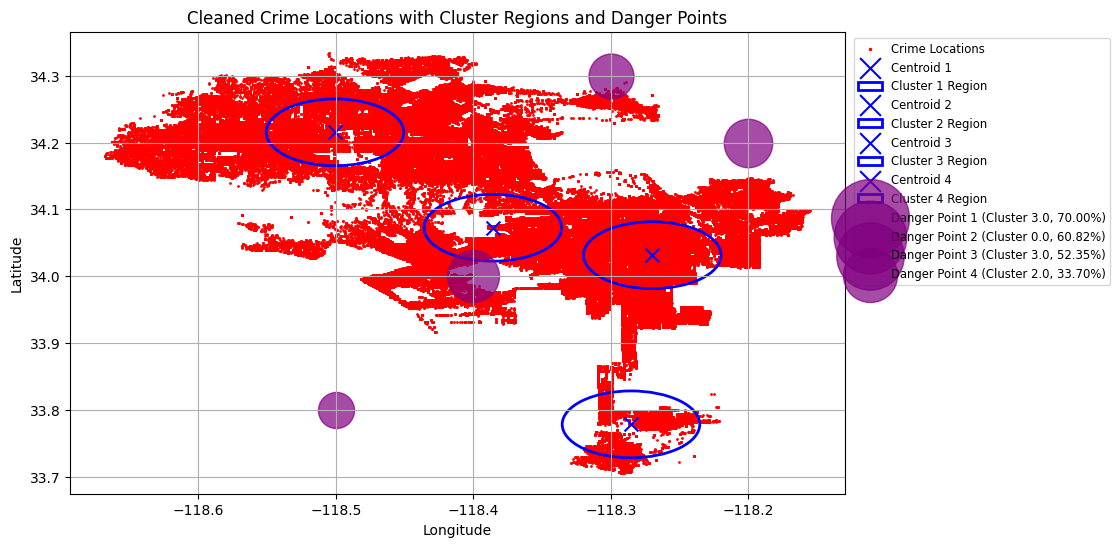

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Load the dataset
df = pd.read_csv('/content/CleanedDataCrime.csv')

# Step 2: Clean the data (if needed)
df_cleaned = df[['LAT', 'LON']]  # Extract latitude and longitude columns

# Step 3: Scale and apply clustering to the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_cleaned)
num_clusters = 4  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(scaled_data)

# Add clustering results to the DataFrame
df_cleaned['Cluster'] = kmeans.labels_

# Mock analyzer with clustering and scaling
class Analyzer:
    def __init__(self, kmeans, scaler):
        self.cluster_centers_ = kmeans.cluster_centers_
        self.scaler = scaler

analyzer = Analyzer(kmeans, scaler)

# Step 4: Function to calculate danger likelihood
def calculate_danger_likelihood(lat, lon, clustered_df, analyzer, density_weight=0.1, distance_weight=0.9):
    # Convert input coordinates to scaled values
    scaled_coords = analyzer.scaler.transform([[lat, lon]])[0]

    # Calculate distances to all centroids
    distances = np.linalg.norm(analyzer.cluster_centers_ - scaled_coords, axis=1)

    # Find the nearest cluster
    nearest_cluster = np.argmin(distances)
    nearest_distance = distances[nearest_cluster]

    # Danger likelihood based on proximity to centroid
    max_distance = np.max(distances)
    proximity_score = max(0, 1 - nearest_distance / max_distance)  # Linear decay

    # Density-based danger (optional, if density is provided)
    cluster_density = clustered_df[clustered_df['Cluster'] == nearest_cluster].shape[0]
    max_density = clustered_df['Cluster'].value_counts().max()
    density_score = cluster_density / max_density

    # Combine the scores
    danger_likelihood = (distance_weight * proximity_score + density_weight * density_score) * 100

    return danger_likelihood, nearest_cluster

# Step 5: Define danger points and calculate danger likelihood for each
danger_points = pd.DataFrame({
    'LAT': [34.0, 34.2, 34.3, 33.8],
    'LON': [-118.4, -118.2, -118.3, -118.5],
    'Danger_Level': [5, 7, 8, 6]  # Placeholder for visualization scaling
})

for idx, row in danger_points.iterrows():
    danger_percentage, cluster_id = calculate_danger_likelihood(
        row['LAT'], row['LON'], df_cleaned, analyzer, density_weight=0.1, distance_weight=0.9
    )
    danger_points.at[idx, 'Cluster'] = cluster_id
    danger_points.at[idx, 'Danger_Percentage'] = danger_percentage

# Print calculated danger points with cluster IDs and percentages
print(danger_points)

# Step 6: Plot the cleaned crime locations
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['LON'], df_cleaned['LAT'], c='red', s=1, label="Crime Locations")

# Plot cluster centroids and their circles
for i, center in enumerate(analyzer.cluster_centers_):
    lat, lon = scaler.inverse_transform([center])[0]
    plt.scatter(lon, lat, c='blue', marker='x', s=100, label=f"Centroid {i+1}")
    plt.gca().add_patch(
        plt.Circle((lon, lat), 0.05, color='blue', fill=False, linewidth=2, label=f"Cluster {i+1} Region")
    )

# Step 7: Plot danger points with dynamic scaling based on danger percentage
for idx, row in danger_points.iterrows():
    plt.scatter(
        row['LON'], row['LAT'],
        s=row['Danger_Percentage'] * 20,  # Scale size by danger percentage
        c='purple',
        alpha=0.7,
        label=f"Danger Point {idx+1} (Cluster {row['Cluster']}, {row['Danger_Percentage']:.2f}%)"
    )

# Customize the plot
plt.title('Cleaned Crime Locations with Cluster Regions and Danger Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend(loc='upper right', markerscale=1.5, fontsize='small', bbox_to_anchor=(1.35, 1))
plt.show()
